In [1]:
import pandas as pd
import h5py
from tqdm import tqdm
import h5py
import numpy as np
import pickle

# Load Data

In [3]:
import h5py
import numpy as np
import pandas as pd

# Load network embeddings
network_filename = '../data/9606.protein.network.embeddings.v12.0 (1).h5'
sequence_filename = '../data/9606.protein.sequence.embeddings.v12.0.h5'

# Load network embeddings
with h5py.File(network_filename, 'r') as f:
    network_embedding = f['embeddings'][:]
    network_proteins = f['proteins'][:]
    network_proteins = [p.decode('utf-8') for p in network_proteins]

# Load sequence embeddings
with h5py.File(sequence_filename, 'r') as f:
    sequence_embedding = f['embeddings'][:]
    sequence_proteins = f['proteins'][:]
    sequence_proteins = [p.decode('utf-8') for p in sequence_proteins]

# Create DataFrames for both embeddings
network_vector_df = pd.DataFrame({
    'network_embedding': [np.array(vec) for vec in network_embedding]
}, index=network_proteins)

sequence_vector_df = pd.DataFrame({
    'sequence_embedding': [np.array(vec) for vec in sequence_embedding]
}, index=sequence_proteins)

# Load the original protein order
with open('protein_order.pkl', 'rb') as f:
    original_protein_order = pickle.load(f)





# Concatenate the embeddings side by side
combined_vector_df = pd.concat([network_vector_df, sequence_vector_df], axis=1)


# Reorder network_vector_df to match original order
combined_vector_df = combined_vector_df.reindex(original_protein_order)

# Verify the ordering matches
assert list(combined_vector_df.index) == original_protein_order, "Ordering mismatch!"

# To create a single column with concatenated vectors
def combine_embeddings(row):
    if isinstance(row['network_embedding'], np.ndarray) and isinstance(row['sequence_embedding'], np.ndarray):
        return np.concatenate([row['network_embedding'], row['sequence_embedding']])
    return None

combined_vector_df['embedding_vector'] = combined_vector_df.apply(combine_embeddings, axis=1)

# Drop the separate embedding columns if you want just the combined one
combined_vector_df = combined_vector_df[['embedding_vector']]

enrichment_df = pd.read_csv('../data/9606.protein.enrichment.terms.v12.0.txt.gz', 
                          sep='\t',  
                          compression='gzip')

enrichment_df.set_index('#string_protein_id', inplace=True)

go_categories = [
    'Biological Process (Gene Ontology)',
]

go_enrichment_df = enrichment_df[enrichment_df['category'].isin(go_categories)]

# Combine Data

In [4]:
# Create mapping of GO descriptions for proteins that have them
go_descriptions = go_enrichment_df.groupby(level=0)['description'].agg(lambda x: list(set(x)))

# Create binary vectors for terms
all_go_terms = sorted(set(term for terms in go_descriptions for term in terms))
term_to_idx = {term: idx for idx, term in enumerate(all_go_terms)}

def terms_to_binary_vector(terms):
    vector = [0] * len(all_go_terms)
    if isinstance(terms, (list, set, tuple)):
        for term in terms:
            if term in term_to_idx:
                vector[term_to_idx[term]] = 1
    return vector

# Create vectors for all proteins in network_vector_df
all_protein_vectors = {}
for protein in network_vector_df.index:
    if protein in go_descriptions:
        all_protein_vectors[protein] = terms_to_binary_vector(go_descriptions[protein])
    else:
        all_protein_vectors[protein] = [0] * len(all_go_terms)

# Create final DataFrame with all proteins from embedding dataset
final_df = pd.DataFrame({
    'go_vector': list(all_protein_vectors.values())
}, index=list(all_protein_vectors.keys()))

Prepare Data

In [5]:
import pickle
# # Load 
with open('train_test_eval_data.pkl', 'rb') as f:
   train_data, test_data, eval_data = pickle.load(f)

# with open('eval_data.pkl', 'rb') as f:
#     eval_data = pickle.load(f)

   
train_pos = train_data['pairs']
train_neg = train_data['nonpairs']

test_pos = test_data['pairs']
test_neg = test_data['nonpairs']

eval_pos = eval_data['pairs'] 
eval_neg = eval_data['nonpairs']

Model Train

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import numpy as np
# First prepare our data
def prepare_data(pairs, nonpairs, combined_vector_df):
    # Convert all pairs to labels and indices
    all_pairs = [(i, j, 1) for i, j in pairs] + [(i, j, 0) for i, j in nonpairs]
    
    # Convert embeddings to torch tensor
    embeddings = torch.tensor(np.vstack(combined_vector_df['embedding_vector'].values), dtype=torch.float32)
    
    return all_pairs, embeddings


# Dataset class
class PairDataset(Dataset):
    def __init__(self, pairs, embeddings):
        self.pairs = pairs
        self.embeddings = embeddings
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        i, j, label = self.pairs[idx]
        return {
            'emb1': self.embeddings[i],
            'emb2': self.embeddings[j],
            'label': torch.tensor(label, dtype=torch.float32)
        }
# at 1% cut off
# Simple element-wise weight model with sigmoid got f1 around 68, at 0.5% around 70
# with a single nn layer(withresidual connection and dropout)-74. more layers just overfits 

# Simple element-wise weight model with sigmoid
class EmbeddingWeights(nn.Module):
    def __init__(self, embedding_dim=1536):  # Fixed method name
        super().__init__()  # Fixed super() call
        self.weights = nn.Parameter(torch.randn(embedding_dim))
        self.sigmoid = nn.Sigmoid()

    def forward(self, emb1, emb2):
        # Apply weights to embeddings
        weighted_emb1 = emb1 * self.weights
        weighted_emb2 = emb2 * self.weights

        # Compute cosine similarity and apply sigmoid
        cos_sim = nn.functional.cosine_similarity(weighted_emb1, weighted_emb2, dim=1)
        return self.sigmoid(cos_sim)

def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    criterion = nn.BCELoss()
    
    with torch.no_grad():
        for batch in data_loader:
            output = model(batch['emb1'], batch['emb2'])
            loss = criterion(output, batch['label'])
            total_loss += loss.item()
            
            predictions = (output > 0.5).float()
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(batch['label'].cpu().numpy())
    
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    f1 = f1_score(all_labels, all_preds)
    avg_loss = total_loss / len(data_loader)
    
    return accuracy, f1, avg_loss

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()
    
    best_f1 = 0
    best_model = None
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            output = model(batch['emb1'], batch['emb2'])
            loss = criterion(output, batch['label'])
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_acc, train_f1, train_loss = evaluate_model(model, train_loader)
        val_acc, val_f1, val_loss = evaluate_model(model, val_loader)
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model = model.state_dict().copy()
        
        print(f'Epoch {epoch+1}:')
        print(f'Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}')
        print(f'Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}\n')
    
    model.load_state_dict(best_model)
    return model

# Prepare data and train
train_pairs_data, embeddings = prepare_data(train_pos, train_neg, combined_vector_df)
test_pairs_data, _ = prepare_data(test_pos, test_neg, combined_vector_df)

train_dataset = PairDataset(train_pairs_data, embeddings)
test_dataset = PairDataset(test_pairs_data, embeddings)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = EmbeddingWeights()

In [9]:
model = train_model(model, train_loader, test_loader, num_epochs=10, learning_rate=1e-3) # this requied about 30 epochs?

Epoch 1:
Train - Loss: 0.6159, Acc: 0.6756, F1: 0.7270
Val   - Loss: 0.6133, Acc: 0.6797, F1: 0.7309

Epoch 2:
Train - Loss: 0.6155, Acc: 0.6759, F1: 0.7269
Val   - Loss: 0.6128, Acc: 0.6804, F1: 0.7311

Epoch 3:
Train - Loss: 0.6151, Acc: 0.6766, F1: 0.7271
Val   - Loss: 0.6123, Acc: 0.6812, F1: 0.7316

Epoch 4:
Train - Loss: 0.6149, Acc: 0.6763, F1: 0.7266
Val   - Loss: 0.6120, Acc: 0.6827, F1: 0.7326

Epoch 5:
Train - Loss: 0.6146, Acc: 0.6767, F1: 0.7269
Val   - Loss: 0.6116, Acc: 0.6832, F1: 0.7330

Epoch 6:
Train - Loss: 0.6144, Acc: 0.6765, F1: 0.7264
Val   - Loss: 0.6114, Acc: 0.6829, F1: 0.7326

Epoch 7:
Train - Loss: 0.6142, Acc: 0.6766, F1: 0.7264
Val   - Loss: 0.6111, Acc: 0.6824, F1: 0.7321

Epoch 8:
Train - Loss: 0.6141, Acc: 0.6762, F1: 0.7260
Val   - Loss: 0.6109, Acc: 0.6818, F1: 0.7314

Epoch 9:
Train - Loss: 0.6139, Acc: 0.6762, F1: 0.7259
Val   - Loss: 0.6108, Acc: 0.6821, F1: 0.7316

Epoch 10:
Train - Loss: 0.6138, Acc: 0.6760, F1: 0.7257
Val   - Loss: 0.6106, Acc:

In [10]:
test_acc, test_f1, test_loss = evaluate_model(model, test_loader)
print("\nFinal Test Results:")
print(f"Accuracy: {test_acc:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Loss: {test_loss:.4f}")


Final Test Results:
Accuracy: 0.6818
F1 Score: 0.7315
Loss: 0.6106


In [11]:
# Prepare evaluation data
eval_pairs_data, _ = prepare_data(eval_pos, eval_neg, combined_vector_df)
eval_dataset = PairDataset(eval_pairs_data, embeddings)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

# Run evaluation
eval_acc, eval_f1, eval_loss = evaluate_model(model, eval_loader)
print(f'Evaluation Results:')
print(f'Accuracy: {eval_acc:.4f}')
print(f'F1 Score: {eval_f1:.4f}')
print(f'Loss: {eval_loss:.4f}')

Evaluation Results:
Accuracy: 0.6550
F1 Score: 0.7016
Loss: 0.6260


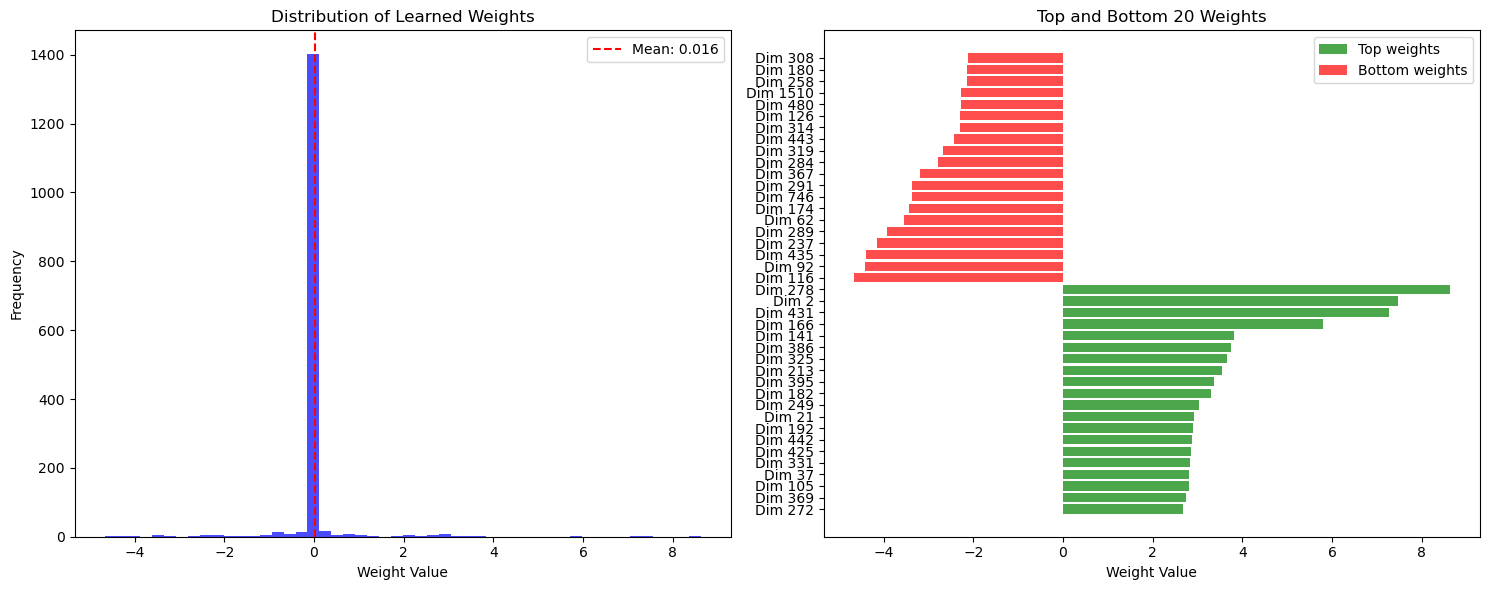


Weight Statistics:
Mean: 0.0157
Std: 0.6709
Min: -4.6680 (Dimension 116)
Max: 8.6326 (Dimension 272)

Number of weights > 0.1: 70
Number of weights < 0.1: 1466
Number of weights ≈ 0 (|w| < 0.1): 1398


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the learned weights
learned_weights = model.weights.detach().numpy()


# Sort weights by magnitude for better visualization
sorted_indices = np.argsort(learned_weights)
sorted_weights = learned_weights[sorted_indices]

# Create figure
plt.figure(figsize=(15, 6))

# Main weight distribution plot
plt.subplot(1, 2, 1)
plt.hist(learned_weights, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Learned Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.axvline(x=learned_weights.mean(), color='red', linestyle='--', label=f'Mean: {learned_weights.mean():.3f}')
plt.legend()

# Top/bottom weights plot
plt.subplot(1, 2, 2)
n_top = 20  # number of top/bottom weights to show

# Plot top and bottom weights
plt.barh(range(n_top), sorted_weights[-n_top:], color='green', alpha=0.7, label='Top weights')
plt.barh(range(n_top, 2*n_top), sorted_weights[:n_top], color='red', alpha=0.7, label='Bottom weights')

plt.yticks(range(2*n_top), 
          [f'Dim {sorted_indices[-i-1]}' for i in range(n_top)] + 
          [f'Dim {sorted_indices[i]}' for i in range(n_top)])
plt.title(f'Top and Bottom {n_top} Weights')
plt.xlabel('Weight Value')
plt.legend()

plt.tight_layout()
plt.show()

# Print some summary statistics
print("\nWeight Statistics:")
print(f"Mean: {learned_weights.mean():.4f}")
print(f"Std: {learned_weights.std():.4f}")
print(f"Min: {learned_weights.min():.4f} (Dimension {sorted_indices[0]})")
print(f"Max: {learned_weights.max():.4f} (Dimension {sorted_indices[-1]})")

# Count weights approximately equal to 0
epsilon = 0.1  # You can adjust this threshold as needed
print(f"\nNumber of weights > {epsilon}: {np.sum(learned_weights > epsilon)}")
print(f"Number of weights < {epsilon}: {np.sum(learned_weights < epsilon)}")


zero_weights = np.sum(np.abs(learned_weights) < epsilon)
print(f"Number of weights ≈ 0 (|w| < {epsilon}): {zero_weights}")

In [13]:
np.save('learned_cosine_weights_network_and_sequence.npy', learned_weights)

Baseline un-weighted cosine sim score.

In [14]:
def evaluate_cosine_baseline(pairs_data, embeddings, weights=None):
    sigmoid = nn.Sigmoid()
    all_preds = []
    all_labels = []
    
    for i, j, label in pairs_data:
        emb1 = embeddings[i].unsqueeze(0)
        emb2 = embeddings[j].unsqueeze(0)
        
        # Apply weights if provided
        if weights is not None:
            emb1 = emb1 * weights
            emb2 = emb2 * weights
        
        # Calculate cosine similarity and apply sigmoid
        cos_sim = nn.functional.cosine_similarity(emb1, emb2)
        output = sigmoid(cos_sim)
        
        # Convert to binary prediction
        pred = (output > 0.5).float()
        
        all_preds.append(pred.item())
        all_labels.append(label)
    
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    f1 = f1_score(all_labels, all_preds)
    
    return accuracy, f1
eval_pairs_data, _ = prepare_data(eval_pos, eval_neg, combined_vector_df)
# Test unweighted version
train_acc, train_f1 = evaluate_cosine_baseline(eval_pairs_data, embeddings)


print(f'Unweighted Baseline Eval - Acc: {train_acc:.4f}, F1: {train_f1:.4f}')


Unweighted Baseline Eval - Acc: 0.5008, F1: 0.6670


In [34]:
# This completely removes dims with less than threshold magnitude weight
def evaluate_cosine_baseline_with_threshold(pairs_data, embeddings, weights=None, threshold=1):
    sigmoid = nn.Sigmoid()
    all_preds = []
    all_labels = []
    
    # If weights provided, create mask for significant dimensions
    if weights is not None:
        significant_dims = torch.abs(weights) >= threshold
        # Filter embeddings and weights to only keep significant dimensions
        filtered_weights = weights[significant_dims]
    
    for i, j, label in pairs_data:
        emb1 = embeddings[i].unsqueeze(0)
        emb2 = embeddings[j].unsqueeze(0)
        
        if weights is not None:
            # Filter to significant dimensions
            emb1 = emb1[:, significant_dims]
            emb2 = emb2[:, significant_dims]
            # Apply remaining weights
            emb1 = emb1 * filtered_weights
            emb2 = emb2 * filtered_weights
        
        # Calculate cosine similarity and apply sigmoid
        cos_sim = nn.functional.cosine_similarity(emb1, emb2)
        output = sigmoid(cos_sim)
        
        pred = (output > 0.5).float()
        all_preds.append(pred.item())
        all_labels.append(label)
    
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    f1 = f1_score(all_labels, all_preds)
    
    # Calculate how many dimensions were kept
    if weights is not None:
        dims_kept = significant_dims.sum().item()
        dims_total = len(weights)
        print(f'Dimensions kept: {dims_kept}/{dims_total} ({(dims_kept/dims_total)*100:.1f}%)')
    
    return accuracy, f1

# Test unweighted version
train_acc, train_f1 = evaluate_cosine_baseline_with_threshold(eval_pairs_data, embeddings, torch.tensor(learned_weights))


print(f'Weighted with Dims removed Eval - Acc: {train_acc:.4f}, F1: {train_f1:.4f}')




Dimensions kept: 57/1536 (3.7%)
Weighted with Dims removed Eval - Acc: 0.6370, F1: 0.6921


ROC Curve unweighted vs weighted

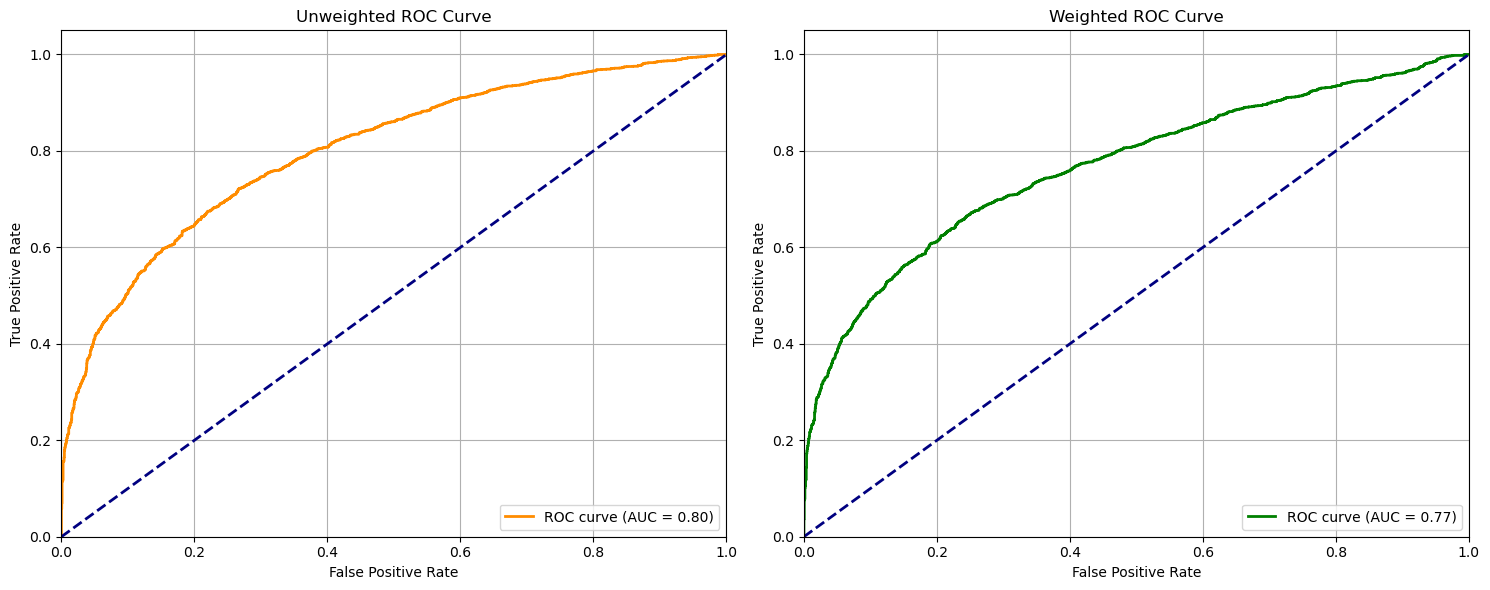

AUC improvement: -0.0340


In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch
import numpy as np
def plot_roc_comparison(eval_loader, learned_weights):
    def get_predictions(dataloader, weights=None):
        all_probs = []
        all_labels = []
        
        for batch in dataloader:
            emb1 = batch['emb1']
            emb2 = batch['emb2']
            labels = batch['label']
            
            if weights is not None:
                # Apply weights
                emb1 = emb1 * torch.from_numpy(weights)
                emb2 = emb2 * torch.from_numpy(weights)
            
            # Compute cosine similarity
            cos_sim = nn.functional.cosine_similarity(emb1, emb2, dim=1)
            probs = torch.sigmoid(cos_sim).cpu().numpy()
            
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())
        
        return np.array(all_probs), np.array(all_labels)

    # Get predictions for both weighted and unweighted
    weighted_probs, true_labels = get_predictions(eval_loader, learned_weights)
    unweighted_probs, _ = get_predictions(eval_loader)

    # Calculate ROC curves
    fpr_weighted, tpr_weighted, _ = roc_curve(true_labels, weighted_probs)
    fpr_unweighted, tpr_unweighted, _ = roc_curve(true_labels, unweighted_probs)
    
    roc_auc_weighted = auc(fpr_weighted, tpr_weighted)
    roc_auc_unweighted = auc(fpr_unweighted, tpr_unweighted)

    # Create side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot unweighted ROC
    ax1.plot(fpr_unweighted, tpr_unweighted, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc_unweighted:.2f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Unweighted ROC Curve')
    ax1.legend(loc="lower right")
    ax1.grid(True)

    # Plot weighted ROC
    ax2.plot(fpr_weighted, tpr_weighted, color='green', lw=2,
             label=f'ROC curve (AUC = {roc_auc_weighted:.2f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Weighted ROC Curve')
    ax2.legend(loc="lower right")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    return roc_auc_unweighted, roc_auc_weighted

# Usage:
learned_weights = model.weights.detach().numpy()
unweighted_auc, weighted_auc = plot_roc_comparison(eval_loader, learned_weights)
print(f'AUC improvement: {weighted_auc - unweighted_auc:.4f}')

Neural Representation Instead

In [16]:
class EmbeddingNN(nn.Module):
    def __init__(self, input_dim, layer_sizes):
        super().__init__()
        
        # Build layers based on input list
        layers = []
        current_dim = input_dim
        
        # If single layer, just do direct projection
        if len(layer_sizes) == 1:
            layers.append(nn.Linear(current_dim, layer_sizes[0]))
        # If multiple layers, add ReLU between them
        else:
            for size in layer_sizes[:-1]:
                layers.extend([
                    nn.Linear(current_dim, size),
                    nn.ReLU()
                ])
                current_dim = size
            # Add final projection layer
            layers.append(nn.Linear(current_dim, layer_sizes[-1]))
        
        self.projection = nn.Sequential(*layers)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, emb1, emb2):
        proj1 = self.projection(emb1)
        proj2 = self.projection(emb2)
        
        cos_sim = nn.functional.cosine_similarity(proj1, proj2, dim=1)
        return self.sigmoid(cos_sim)

In [19]:
modelNN = EmbeddingNN(input_dim=1536, layer_sizes=[5])

In [23]:
modelNN = train_model(modelNN, train_loader, test_loader, num_epochs=5, learning_rate=1e-4)

Epoch 1:
Train - Loss: 0.5557, Acc: 0.7624, F1: 0.7991
Val   - Loss: 0.5800, Acc: 0.7195, F1: 0.7692

Epoch 2:
Train - Loss: 0.5549, Acc: 0.7623, F1: 0.7997
Val   - Loss: 0.5798, Acc: 0.7216, F1: 0.7713

Epoch 3:
Train - Loss: 0.5545, Acc: 0.7648, F1: 0.8004
Val   - Loss: 0.5803, Acc: 0.7201, F1: 0.7690

Epoch 4:
Train - Loss: 0.5539, Acc: 0.7642, F1: 0.8005
Val   - Loss: 0.5801, Acc: 0.7208, F1: 0.7704

Epoch 5:
Train - Loss: 0.5535, Acc: 0.7648, F1: 0.8011
Val   - Loss: 0.5801, Acc: 0.7216, F1: 0.7710



In [24]:
# Prepare evaluation data
eval_pairs_data, _ = prepare_data(eval_pos, eval_neg, combined_vector_df)
eval_dataset = PairDataset(eval_pairs_data, embeddings)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

# Run evaluation
eval_acc, eval_f1, eval_loss = evaluate_model(modelNN, eval_loader)
print(f'Evaluation Results:')
print(f'Accuracy: {eval_acc:.4f}')
print(f'F1 Score: {eval_f1:.4f}')
print(f'Loss: {eval_loss:.4f}')

Evaluation Results:
Accuracy: 0.7043
F1 Score: 0.7573
Loss: 0.5885


In [25]:
torch.save(modelNN, 'neural_rep_network_and_sequence.pt')

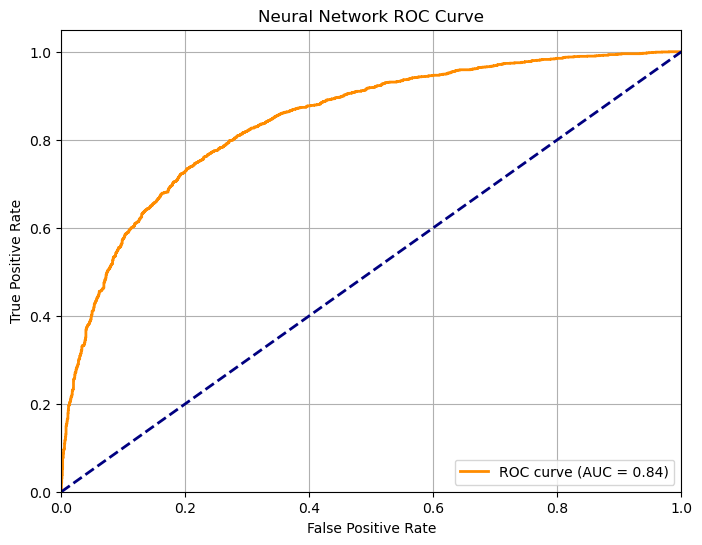

AUC: 0.8419


In [26]:
def plot_neural_net_roc(model, eval_loader):
    model.eval()
    all_probs = []
    all_labels = []
    
    # Get predictions
    with torch.no_grad():
        for batch in eval_loader:
            emb1 = batch['emb1']
            emb2 = batch['emb2']
            labels = batch['label']
            
            outputs = model(emb1, emb2)
            all_probs.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Neural Network ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return roc_auc

# Usage:
auc_score = plot_neural_net_roc(modelNN, eval_loader)
print(f'AUC: {auc_score:.4f}')

Total pairs: 4000
Pairs with similarity > 0: 2624
Pairs with similarity <= 0: 1376

Mean similarity for positive pairs: 0.361
Mean similarity for negative pairs: 0.001


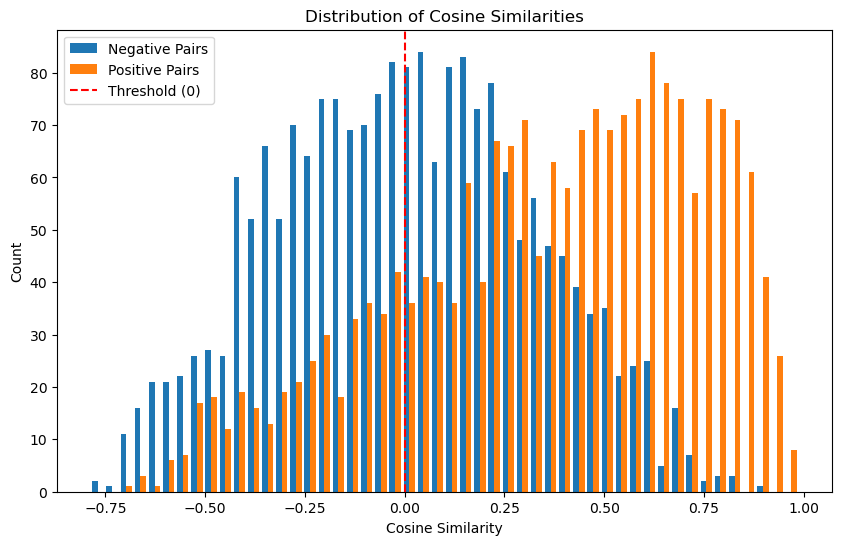

In [30]:
def analyze_cosine_similarities(pairs_data, embeddings, learned_weights=None, modelNN=None):
    all_similarities = []
    positive_similarities = []
    negative_similarities = []
    count_over_threshold = 0
    
    for i, j, label in pairs_data:
        emb1 = embeddings[i].unsqueeze(0)
        emb2 = embeddings[j].unsqueeze(0)
        
        # Apply learned weights if provided
        if learned_weights is not None:
            emb1 = emb1 * learned_weights
            emb2 = emb2 * learned_weights
            
        # Apply neural network projection if provided
        if modelNN is not None:
            # Use the projection part of the network without the sigmoid
            emb1 = modelNN.projection(emb1)
            emb2 = modelNN.projection(emb2)
        
        cos_sim = nn.functional.cosine_similarity(emb1, emb2).item()
        all_similarities.append(cos_sim)
        
        if cos_sim > 0:
            count_over_threshold += 1
            
        if label == 1:
            positive_similarities.append(cos_sim)
        else:
            negative_similarities.append(cos_sim)
    
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.hist([negative_similarities, positive_similarities], label=['Negative Pairs', 'Positive Pairs'], bins=50)
    plt.axvline(x=0, color='r', linestyle='--', label='Threshold (0)')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Count')
    plt.title('Distribution of Cosine Similarities')
    plt.legend()
    
    print(f"Total pairs: {len(pairs_data)}")
    print(f"Pairs with similarity > 0: {count_over_threshold}")
    print(f"Pairs with similarity <= 0: {len(pairs_data) - count_over_threshold}")
    print(f"\nMean similarity for positive pairs: {np.mean(positive_similarities):.3f}")
    print(f"Mean similarity for negative pairs: {np.mean(negative_similarities):.3f}")
    
    return all_similarities

_ = analyze_cosine_similarities(eval_pairs_data, embeddings, learned_weights=learned_weights)